# Машинное обучение, ФКН ВШЭ

# Практическое задание 13. Рекомендательные системы

## Общая информация
**Дата выдачи: 20.05.2023**

**Мягкий дедлайн: 03.06.2023 23:59 MSK**

**Жёсткий дедлайн: 08.06.2023 23:59 MSK**

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — **11** баллов + **2.5** бонусных.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-13-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## О задании

В этой работе мы будем решать задачу рекомендации музыки. То есть мы поставим целью получить модель, которая для каждого пользователя будет возвращать набор треков, наиболее похожих на те, что он уже слушал. В первой части мы разберемся с memory-based подходом и моделью со скрытыми переменными. Это не очень мощные методы, но зато они позволяют строить предсказания почти моментально. Затем, во второй части, мы обратим внимание на то, что датасет содержит огромное число треков и воспользуемся результатами уже построенных быстрых моделей для сокращения списка кандидатов до разумного количества. После этого проведем ранжирование среди кандидатов с помощью сильной, но чуть более медленной модели, и отберем самые лучшие варианты. Такой двухэтапный алгоритм построения рекомендаций изображен на картинке.


![photo_2023-05-17%2020.06.18.jpeg](attachment:photo_2023-05-17%2020.06.18.jpeg)

Приступим!

Все шаблоны ниже можно переписывать по своему усмотрению.

In [2]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [3]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [4]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (0.5 балл).** Реализуйте метрику $MAP@k$.

In [5]:
def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
    predicted_df = pd.DataFrame(predicted)
    map = 0

    for i, r_u in enumerate(relevant):
        rel = predicted_df.iloc[i].isin(r_u)
        prec_at_k = np.cumsum(rel)[:k] / np.arange(1, k + 1)
        avg_prec_at_k = (rel * prec_at_k).sum() / min(k, len(r_u))
        map += avg_prec_at_k
    
    return map / len(relevant)

In [6]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7] 
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [7]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [8]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [9]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [10]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [11]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [12]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [13]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [14]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (0.5 балла).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [15]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.
        
    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []
        
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪

        for uid in np.arange(self.n_users):
            test_preds.append(self.recommend(uid))

        test_preds = self.remove_train_items(test_preds, k)
        return test_preds[test_users]

### Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать меру Жаккара:

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Во всех формулах 
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.2 (0.5 балла).** Реализуйте функцию подсчета меры Жаккара.

Функция принимает матрицу оценок и вектор оценок пользователя $u$ и возвращает вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [16]:
def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
    intersec = (ratings * user_vector).sum(axis=1)
    union = ratings.sum(axis=1) + user_vector.sum() - intersec
    return intersec / union

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок. Значение парамметра `alpha` можно менять по своему усмотрению так, чтобы оно было разумным.

In [35]:
class User2User(BaseModel):
    def __init__(self, ratings):
        super().__init__(ratings)

        self.similarity_func = jaccard
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        return self.similarity_func(self.R, user_vector)

    def recommend(self, uid: int):
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        sim_values = self.similarity(self.R[uid])
        users_mask = sim_values > self.alpha
        users_mask[uid] = False

        sim_values = users_mask * sim_values

        eps = 1e-7
        ratings = (sim_values @ self.R) / (sim_values.sum() + eps)

        return np.argsort(-ratings)

**Задание 5 (0.5 балл).** Постройте график зависимости значений $MAP@k$ от разных $k$ при рекомендации на основе меры Жаккара, сравните его с рекомендициями самых популярных треков и случайных. Какой из трех способов рекомендаций оказался лучшим?

In [36]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪

class PopularModel(BaseModel):
    def __init__(self, ratings):
        super().__init__(ratings)

    def recommend(self, uid: int):
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        items_freq = self.R.sum(axis=0)
        return np.argsort(-items_freq)

class RandomModel(BaseModel):
    def __init__(self, ratings):
        super().__init__(ratings)

    def recommend(self, uid: int):
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        indices = np.arange(self.n_items)
        np.random.shuffle(indices)
        return indices

In [37]:
def calculate_metrics(model, k_values):
    metrics = []
    test_pred = model.get_test_recommendations(max(k_values))

    for k_value in tqdm(k_values):
        metrics.append(mapk(test_relevant, test_pred, k_value))

    return metrics

In [38]:
k = np.arange(5, 30, dtype=int)

In [39]:
model = User2User(train_ratings)
u2u_metrics = calculate_metrics(model, k)

  0%|          | 0/25 [00:00<?, ?it/s]

In [40]:
model = PopularModel(train_ratings)
pop_metrics = calculate_metrics(model, k)

  0%|          | 0/25 [00:00<?, ?it/s]

In [41]:
model = RandomModel(train_ratings)
rand_metrics = calculate_metrics(model, k)

  0%|          | 0/25 [00:00<?, ?it/s]

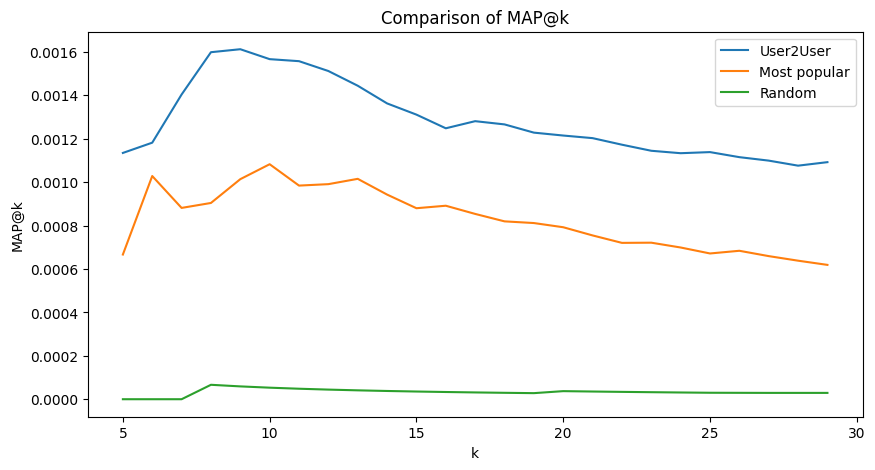

In [42]:
plt.figure(figsize=(10, 5))

plt.plot(k, u2u_metrics)
plt.plot(k, pop_metrics)
plt.plot(k, rand_metrics)
plt.xlabel("k")
plt.ylabel("MAP@k")
plt.legend(["User2User", "Most popular", "Random"]);
plt.title("Comparison of MAP@k");

Хоть User2User подход не очень интеллектуальный, ожидаемо показал лучшие результаты.

**Бонус (1 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

In [44]:
# your code here: ‿︵‿︵ヽ(°□° )ノ︵‿︵‿
from scipy.sparse import csr_matrix, csr_array

class SparseBaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        row = self.ratings['userId']
        col = self.ratings['trackId']
        data = np.ones(len(self.ratings))

        self.R = csr_matrix((data, (row, col)), shape=(self.n_users, self.n_items))
        
    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []
        
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪

        for uid in np.arange(self.n_users):
            test_preds.append(self.recommend(uid))

        test_preds = self.remove_train_items(test_preds, k)
        return test_preds[test_users]


class SparseUser2User(SparseBaseModel):
    def __init__(self, ratings):
        super().__init__(ratings)

        self.similarity_func = jaccard
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        return self.similarity_func(self.R, user_vector)

    def recommend(self, uid: int):
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        sim_values = self.similarity(csr_array(self.R[uid]))
        users_mask = sim_values > self.alpha
        users_mask[uid] = False

        sim_values = np.multiply(users_mask, sim_values)

        eps = 1e-7
        ratings = (sim_values.T @ self.R) / (sim_values.sum() + eps)
        return np.argsort(-np.asarray(ratings).squeeze(axis=0))

In [45]:
model = SparseUser2User(train_ratings)
sparse_u2u_metrics = calculate_metrics(model, k)

  0%|          | 0/25 [00:00<?, ?it/s]

In [47]:
assert u2u_metrics == sparse_u2u_metrics

In [45]:
%timeit User2User(train_ratings).get_test_recommendations(25)

25.7 s ± 1.22 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [46]:
%timeit SparseUser2User(train_ratings).get_test_recommendations(25)

2.96 s ± 320 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [59]:
model = SparseUser2User(train_ratings)
user_id = np.random.randint(0, model.n_users)

In [61]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
212,Let's Get It Started,['Black Eyed Peas']
757,Take A Look Around,['Limp Bizkit']
886,In The Army Now,['Status Quo']
927,Set The World On Fire,['E-Type']
1056,Don't Speak,['No Doubt']
1105,Moskau,['Rammstein']
1129,Enter Sandman,['Metallica']
1138,My Humps,['Black Eyed Peas']
1155,30 Minutes,['t.A.T.u.']
1275,Maniac,['Michael Sembello']


In [57]:
preds = model.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

Predicted tracks:


,name,artists
805,Zombie,['The Cranberries']
7780,ИСКАЛА,['Земфира']
1137,Nothing Else Matters,['Metallica']
1131,The Unforgiven,['Metallica']
2555,Californication,['Red Hot Chili Peppers']
17103,Просвистела,['ДДТ']
1073,Smells Like Teen Spirit,['Nirvana']
5521,Полковнику никто не пишет,['Би-2']
4032,Bring Me To Life,['Evanescence']
40209,Выхода нет,['Сплин']


Саша Шабалин почистил track_info и треков может не быть и тогда будет падать...

In [67]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
59229,Мальчик на девятке,['DEAD BLONDE']
59276,Терентий,['ЭЛЕКТРОСЛАБОСТЬ']
59422,Hypnodancer,['Little Big']
59956,Золото,['Супер Жорик']
60761,Gin Tonic (Think About the Way),"['Dino Brown', 'Paky Francavilla', 'Ice MC', '..."
60765,Сияй,"[""Ramil'""]"
60806,Сердце Лёд,['Cream Soda']
61560,Втюрилась,['Дора']
61819,Sad Song,['MARUV']
62532,Живи без остатка,"['Noize MC', 'Монеточка']"


### Часть 2. Модель со скрытыми переменными: ALS

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно. 

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

__P. S.__ Заметьте, что описанная модель предназначена для работы только с __явной__ информацией. В нашем случае от модели будет требоваться всегда возвращать 1, так как мы считаем ошибку только по парам, о которых получили фидбек. Поэтому логично подумать, что постановка задачи не имеет смысла. Однако, на практике оказывается, что из-за случайности в инициализации матриц $P$ и $Q$, обученные векторы для всех треков и пользователей в конце обучения получаются разными. Поэтому модель все же не лишена смысла.

__P. P. S.__ Для более разумной работы с неявной информацией был предложен метод iALS, его описание можно найти в лекции. Ниже будет бонус на его реализацию.

**Задание 6 (0.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

**SGD:**

Выбираем случайную пару $(u, i) \in R$ и делаем градиентный шаг.

$$
\frac{\partial{L}}{\partial{p_u}} = 2 (\langle p_u, q_i \rangle - r_{ui}) q_i + 2 \lambda p_u\\
\frac{\partial{L}}{\partial{q_i}} = 2 (\langle p_u, q_i \rangle - r_{ui}) p_u + 2 \lambda q_i
\\
p_u^{(k+1)} = p_u^{(k)} - \eta_k \frac{\partial{L}}{\partial{p_u}} \left (p_u^{(k)}, q_i^{(k)}\right)
\\
q_i^{(k+1)} = q_i^{(k)} - \eta_k \frac{\partial{L}}{\partial{q_i}} \left (p_u^{(k)}, q_i^{(k)}\right)
$$

**ALS:**

Так как вместо пропусков в матрице рейтингов мы ставим 0, то можно записать задачу на матричном языке.

$$
L(P, Q) = ||R-PQ^T||_F^2 + \lambda ||P||_F^2 + \lambda ||Q||_F^2 \to min_{P, Q}\\
R \in \mathbb{R}^{m \times n}, P \in \mathbb{R}^{m \times d}, Q \in \mathbb{R}^{n \times d}
$$

Фиксируем матрицу Q, оптимизируем по P.
$$
L(P, Q) = \langle R, R \rangle - 2 \langle R, P Q^T \rangle + \langle PQ^T, PQ^T \rangle + \lambda ||P||_F^2 + \lambda ||Q||_F^2\\
dL = -2 \langle R Q, dP \rangle + d(tr(QP^TPQ^T)) + 2 \langle \lambda P, dP \rangle =\\
-2 \langle R Q, dP \rangle + 2 tr(Q^T QP^TdP) + 2 \langle \lambda P, dP \rangle =\\
-2 \langle R Q, dP \rangle + 2 \langle P Q^T Q, dP \rangle + \langle \lambda P, dP \rangle\\
-R Q + P Q^T Q + \lambda P = 0\\
P^* = RQ (Q^T Q + \lambda I)^{-1}
$$

И наоборот.
$$
dL = -2 \langle R^T P, dQ \rangle + 2 \langle Q P^T P, dQ \rangle + 2 \langle \lambda Q, dQ \rangle\\
-R^T P + Q P^T P + \lambda Q = 0\\
Q^* = R^T P (P^T P + \lambda I)^{-1}
$$

Обсудим аналитическую формулу для P. Хочу отметить, что в выражении $R * Q$ будем действовать на строчки матрицы $Q$, суммируя только те, которые соответствуют релевантным парам. И это будет эквивалентно формуле с лекции. Однако $Q^T Q = \sum_{i} q_i^T q_i$, где $q_i$ - строчка матрицы $Q$, и это не то же самое, что $\sum_{i: \exists r_{ui}} q_i^T q_i$. Я оставил первый вариант, чтобы не обращать n_users раз эти матрицы.

**Задание 7 (1.5 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [48]:
class LatentFactorModel(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim
        
        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = 0.0003
        self.lamb = 0.01

    def _L_grad_p(self, p_u, q_i, r_ui):
        return 2 * (np.dot(p_u, q_i) - r_ui) * q_i + 2 * self.lamb * p_u

    def _L_grad_q(self, p_u, q_i, r_ui):
        return 2 * (np.dot(p_u, q_i) - r_ui) * p_u + 2 * self.lamb * q_i

    def fit(self, num_iters=10):

        for epoch in tqdm(range(num_iters)):

            if self.mode == 'sgd':
                # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
                rating_pair = self.ratings.sample(1).iloc[0]
                p_u = self.P[rating_pair["userId"]]
                q_i = self.Q[rating_pair["trackId"]]
                r_ui = self.R[rating_pair["userId"], rating_pair["trackId"]]

                p_u_next = p_u - self.lr * self._L_grad_p(p_u, q_i, r_ui)
                q_i_next = q_i - self.lr * self._L_grad_q(p_u, q_i, r_ui)

                self.P[rating_pair["userId"]] = p_u_next
                self.Q[rating_pair["trackId"]] = q_i_next

            elif self.mode == 'als':
                # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
                self.P = self.R @ (self.Q @ np.linalg.inv(self.Q.T @ self.Q + self.lamb * np.eye(self.Q.shape[1])))
                self.Q = self.R.T @ (self.P @ np.linalg.inv(self.P.T @ self.P + self.lamb * np.eye(self.P.shape[1])))


    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

**Задание 8 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

__P. S.__ Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

__P. P. S.__ Методу SGD свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

In [51]:
#!pip3 install optuna
import optuna

In [95]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪
def objective(trial):
    dim = trial.suggest_int(name="dim", low=64, high=512, step=64)
    k = trial.suggest_int(name="k", low=1, high=10)
    model = LatentFactorModel(train_ratings, dim=dim, mode="als")
    model.fit()
    test_pred = model.get_test_recommendations(k)
    return mapk(test_relevant, test_pred, k)    

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2023-06-03 21:26:24,636] A new study created in memory with name: no-name-ea6e04ac-7a4e-4ad6-900d-137169eaa15d


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-06-03 21:27:04,978] Trial 0 finished with value: 0.0010638297872340426 and parameters: {'dim': 384, 'k': 2}. Best is trial 0 with value: 0.0010638297872340426.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-06-03 21:27:31,858] Trial 1 finished with value: 0.0003324468085106383 and parameters: {'dim': 256, 'k': 8}. Best is trial 0 with value: 0.0010638297872340426.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-06-03 21:27:43,294] Trial 2 finished with value: 0.0017730496453900707 and parameters: {'dim': 64, 'k': 6}. Best is trial 2 with value: 0.0017730496453900707.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-06-03 21:28:10,753] Trial 3 finished with value: 0.0005319148936170213 and parameters: {'dim': 256, 'k': 9}. Best is trial 2 with value: 0.0017730496453900707.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-06-03 21:28:26,085] Trial 4 finished with value: 0.0015011820330969267 and parameters: {'dim': 128, 'k': 6}. Best is trial 2 with value: 0.0017730496453900707.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-06-03 21:28:59,887] Trial 5 finished with value: 0.0 and parameters: {'dim': 320, 'k': 2}. Best is trial 2 with value: 0.0017730496453900707.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-06-03 21:29:47,266] Trial 6 finished with value: 0.0027482269503546096 and parameters: {'dim': 448, 'k': 4}. Best is trial 6 with value: 0.0027482269503546096.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-06-03 21:30:09,409] Trial 7 finished with value: 0.0007782843633907464 and parameters: {'dim': 192, 'k': 10}. Best is trial 6 with value: 0.0027482269503546096.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-06-03 21:31:05,948] Trial 8 finished with value: 0.00047281323877068556 and parameters: {'dim': 512, 'k': 6}. Best is trial 6 with value: 0.0027482269503546096.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-06-03 21:31:53,759] Trial 9 finished with value: 0.0007092198581560283 and parameters: {'dim': 448, 'k': 3}. Best is trial 6 with value: 0.0027482269503546096.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-06-03 21:32:50,973] Trial 10 finished with value: 0.0016843971631205672 and parameters: {'dim': 512, 'k': 4}. Best is trial 6 with value: 0.0027482269503546096.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-06-03 21:33:01,467] Trial 11 finished with value: 0.0018297872340425532 and parameters: {'dim': 64, 'k': 5}. Best is trial 6 with value: 0.0027482269503546096.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-06-03 21:33:12,408] Trial 12 finished with value: 0.001152482269503546 and parameters: {'dim': 64, 'k': 4}. Best is trial 6 with value: 0.0027482269503546096.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-06-03 21:33:53,244] Trial 13 finished with value: 0.0013297872340425532 and parameters: {'dim': 384, 'k': 4}. Best is trial 6 with value: 0.0027482269503546096.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-06-03 21:34:14,546] Trial 14 finished with value: 0.0 and parameters: {'dim': 192, 'k': 1}. Best is trial 6 with value: 0.0027482269503546096.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-06-03 21:34:54,209] Trial 15 finished with value: 0.0007598784194528874 and parameters: {'dim': 384, 'k': 7}. Best is trial 6 with value: 0.0027482269503546096.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-06-03 21:35:27,366] Trial 16 finished with value: 0.0008510638297872341 and parameters: {'dim': 320, 'k': 5}. Best is trial 6 with value: 0.0027482269503546096.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-06-03 21:36:15,216] Trial 17 finished with value: 0.00028368794326241134 and parameters: {'dim': 448, 'k': 5}. Best is trial 6 with value: 0.0027482269503546096.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-06-03 21:36:30,308] Trial 18 finished with value: 0.0018912529550827422 and parameters: {'dim': 128, 'k': 3}. Best is trial 6 with value: 0.0027482269503546096.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-06-03 21:36:50,736] Trial 19 finished with value: 0.00425531914893617 and parameters: {'dim': 192, 'k': 1}. Best is trial 19 with value: 0.00425531914893617.


In [52]:
#best params for ALS:
#dim=192
#k=1

In [58]:
def objective2(trial):
    dim = trial.suggest_int(name="dim", low=64, high=512, step=64)
    k = trial.suggest_int(name="k", low=1, high=10)
    model = LatentFactorModel(train_ratings, dim=dim, mode="sgd")
    model.fit(5000)
    test_pred = model.get_test_recommendations(k)
    return mapk(test_relevant, test_pred, k)    

study2 = optuna.create_study(direction="maximize")
study2.optimize(objective2, n_trials=20)

[I 2023-06-04 08:14:17,647] A new study created in memory with name: no-name-475ed98d-1963-4a01-9e92-831161c300ef


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-06-04 08:14:40,144] Trial 0 finished with value: 0.0 and parameters: {'dim': 64, 'k': 5}. Best is trial 0 with value: 0.0.


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-06-04 08:15:00,773] Trial 1 finished with value: 0.0 and parameters: {'dim': 64, 'k': 3}. Best is trial 0 with value: 0.0.


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-06-04 08:15:28,056] Trial 2 finished with value: 0.0 and parameters: {'dim': 448, 'k': 10}. Best is trial 0 with value: 0.0.


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-06-04 08:15:52,575] Trial 3 finished with value: 0.002127659574468085 and parameters: {'dim': 192, 'k': 3}. Best is trial 3 with value: 0.002127659574468085.


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-06-04 08:16:19,063] Trial 4 finished with value: 0.0028368794326241132 and parameters: {'dim': 384, 'k': 3}. Best is trial 4 with value: 0.0028368794326241132.


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-06-04 08:16:44,036] Trial 5 finished with value: 0.0 and parameters: {'dim': 256, 'k': 6}. Best is trial 4 with value: 0.0028368794326241132.


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-06-04 08:17:08,200] Trial 6 finished with value: 0.0 and parameters: {'dim': 192, 'k': 4}. Best is trial 4 with value: 0.0028368794326241132.


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-06-04 08:17:35,389] Trial 7 finished with value: 9.456264775413712e-05 and parameters: {'dim': 448, 'k': 9}. Best is trial 4 with value: 0.0028368794326241132.


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-06-04 08:17:55,824] Trial 8 finished with value: 0.00010131712259371833 and parameters: {'dim': 64, 'k': 7}. Best is trial 4 with value: 0.0028368794326241132.


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-06-04 08:18:20,504] Trial 9 finished with value: 0.0 and parameters: {'dim': 256, 'k': 9}. Best is trial 4 with value: 0.0028368794326241132.


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-06-04 08:18:48,244] Trial 10 finished with value: 0.0 and parameters: {'dim': 512, 'k': 1}. Best is trial 4 with value: 0.0028368794326241132.


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-06-04 08:19:14,680] Trial 11 finished with value: 0.0 and parameters: {'dim': 384, 'k': 2}. Best is trial 4 with value: 0.0028368794326241132.


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-06-04 08:19:40,259] Trial 12 finished with value: 0.0 and parameters: {'dim': 320, 'k': 4}. Best is trial 4 with value: 0.0028368794326241132.


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-06-04 08:20:04,177] Trial 13 finished with value: 0.0 and parameters: {'dim': 192, 'k': 1}. Best is trial 4 with value: 0.0028368794326241132.


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-06-04 08:20:29,602] Trial 14 finished with value: 0.0 and parameters: {'dim': 320, 'k': 3}. Best is trial 4 with value: 0.0028368794326241132.


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-06-04 08:20:53,171] Trial 15 finished with value: 0.0 and parameters: {'dim': 192, 'k': 3}. Best is trial 4 with value: 0.0028368794326241132.


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-06-04 08:21:19,304] Trial 16 finished with value: 0.0 and parameters: {'dim': 384, 'k': 6}. Best is trial 4 with value: 0.0028368794326241132.


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-06-04 08:21:40,948] Trial 17 finished with value: 0.0 and parameters: {'dim': 128, 'k': 2}. Best is trial 4 with value: 0.0028368794326241132.


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-06-04 08:22:07,466] Trial 18 finished with value: 0.00017021276595744682 and parameters: {'dim': 384, 'k': 5}. Best is trial 4 with value: 0.0028368794326241132.


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-06-04 08:22:35,365] Trial 19 finished with value: 0.0 and parameters: {'dim': 512, 'k': 7}. Best is trial 4 with value: 0.0028368794326241132.


In [59]:
study2.best_params
# SGD best params
# dim=384
# k=3

{'dim': 384, 'k': 3}

In [54]:
def als_fit_experiment():
    metrics = []

    k = 5
    iters = np.arange(5, 30, 5)

    for num_iters in tqdm(iters):
        model = LatentFactorModel(train_ratings, dim=200, mode="als")
        model.fit(num_iters)
        test_pred = model.get_test_recommendations(k)
        metrics.append(mapk(test_relevant, test_pred, k))
    return iters, metrics

num_iters, als_iters_metrics = als_fit_experiment()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

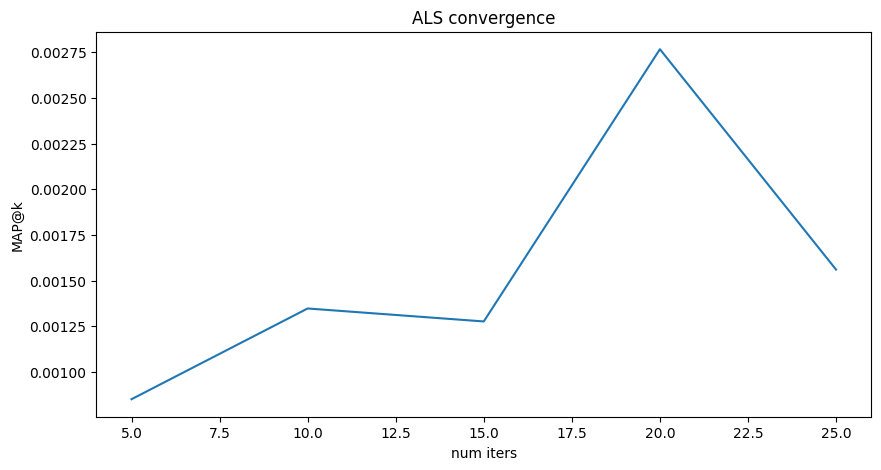

In [56]:
plt.figure(figsize=(10, 5))

plt.plot(num_iters, als_iters_metrics)
plt.xlabel("num iters")
plt.ylabel("MAP@k")
plt.title("ALS convergence");

In [61]:
def sgd_fit_experiment():
    metrics = []

    k = 3
    iters = np.arange(5000, 50000, 5000)

    for num_iters in tqdm(iters):
        model = LatentFactorModel(train_ratings, dim=380, mode="sgd")
        model.fit(num_iters)
        test_pred = model.get_test_recommendations(k)
        metrics.append(mapk(test_relevant, test_pred, k))
    return iters, metrics

num_iters2, sgd_iters_metrics = sgd_fit_experiment()

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/35000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/45000 [00:00<?, ?it/s]

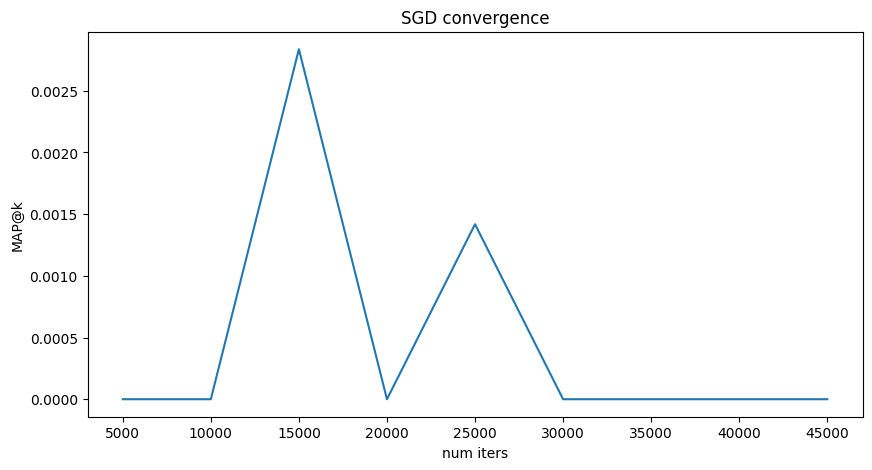

In [62]:
plt.figure(figsize=(10, 5))

plt.plot(num_iters2, sgd_iters_metrics)
plt.xlabel("num iters")
plt.ylabel("MAP@k")
plt.title("SGD convergence");

In [65]:
model = LatentFactorModel(train_ratings, dim=200, mode="als")
model.fit(20)
als_metrics = calculate_metrics(model, k)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [66]:
model = LatentFactorModel(train_ratings, dim=380, mode="sgd")
model.fit(20000)
sgd_metrics = calculate_metrics(model, k)

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

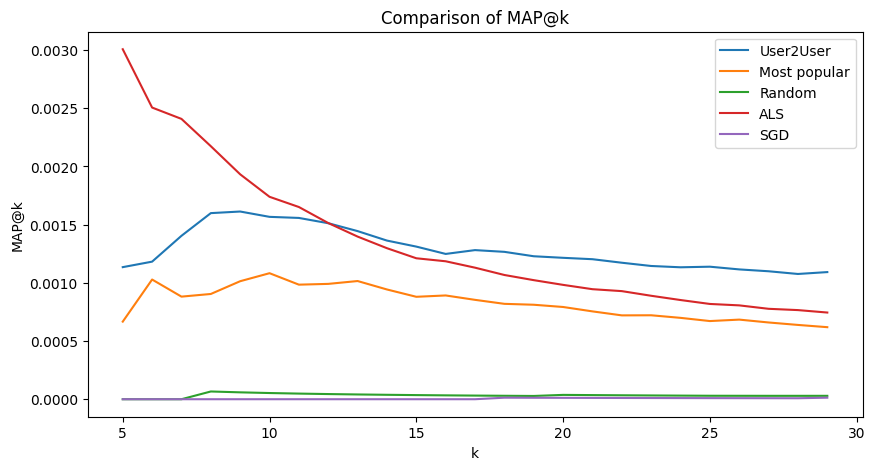

In [68]:
plt.figure(figsize=(10, 5))

plt.plot(k, u2u_metrics)
plt.plot(k, pop_metrics)
plt.plot(k, rand_metrics)
plt.plot(k, als_metrics)
plt.plot(k, sgd_metrics)
plt.xlabel("k")
plt.ylabel("MAP@k")
plt.legend(["User2User", "Most popular", "Random", "ALS", "SGD"]);
plt.title("Comparison of MAP@k");

ALS неплохо справился и вообще выглядит как наиболее разумный метод из рассматриваемых. Во-первых, в нем присутствует обучение, в отличие от User2User. Во-вторых, кажется он более устойчивый при обучении, чем SGD.

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [69]:
model = LatentFactorModel(train_ratings, dim=200, mode="als")
model.fit(20)

  0%|          | 0/20 [00:00<?, ?it/s]

In [70]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = model.Q @ model.Q[example_trackId]
preds = preds / np.sqrt((model.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [71]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
2058,Последний герой,['КИНО'],0.708300
9689,Bicycle Race,['Queen'],0.672515
5153,Stormbringer,['Deep Purple'],0.672515
16637,Zodiac,['Zodiac'],0.672515
5570,Моё сердце,['Сплин'],0.633444
17331,"Последнее письмо (Гудбай, Америка)",['Nautilus Pompilius'],0.615497
39732,"Another Brick In The Wall, Pt. 2",['Pink Floyd'],0.610291
16224,Пока горит свеча,['Машина времени'],0.608722
11476,I Want It All,['Queen'],0.596529


**Бонус (1.5 балла).**

Постройте модель iALS и сравните ее качество с обучением ALS и SGD.

В методе iALS вводятся $c_{ui} = 1 + \alpha r_{ui}$. И функционал переписывается как.

$$
\sum c_{ui} (r_{ui} - \langle p_u, q_i \rangle)^2 + \lambda \sum_u ||p_u||^2 + \lambda \sum_i ||q_i||^2
$$

Запишем в матричном виде как

$$
L(P, Q) = ||C \circ (R-PQ^T)||_F^2 + \lambda ||P||_F^2 + \lambda ||Q||_F^2 \to min_{P, Q}\\
$$
где $C = \sqrt{\mathbb{1} + \alpha R}$, $\mathbb{1}$ - матрица из единиц.

Вывод получается аналогичным ALS, в частности, если приравнять производную по $P$ к нулю, то получим.

$$
(C^2 \circ (PQ^T)) Q - (C^2 \circ R) Q + \lambda P = 0
$$

И тогда
$$
p_u = \left( \sum_i c_{ui} r_{ui} q_i \right) \left (\sum_i c_{ui} q^T_i q_i + \lambda I \right )^{-1}
$$

$c_{ui}$ тут исходные, а не элементы матрицы C.

In [72]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪
class iALS(BaseModel):
    def __init__(self, ratings, dim=128, alpha=50):
        super().__init__(ratings)
        self.dim = dim
        self.alpha = alpha

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))
        self.C = 1 + self.alpha * self.R

        self.lamb = 0.01

    def fit(self, num_iters=10):

        for epoch in tqdm(range(num_iters)):
            
            self.P = self.R @ (self.Q @ np.linalg.inv(self.Q.T @ self.Q + self.lamb * np.eye(self.Q.shape[1])))
            self.Q = self.R.T @ (self.P @ np.linalg.inv(self.P.T @ self.P + self.lamb * np.eye(self.P.shape[1])))

    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

### Часть 3. Второй уровень рекомендаций.

Выше мы построили простейшие модели, которые показывают не слишком высокое качество, но зато работают очень быстро. Воспользуемся ими для того, чтобы отобрать некоторое количество наиболее перспективных треков, которые мы сможем отранжировать уже более сложной моделью (в нашем случае это будет [CatBoost](https://catboost.ai/en/docs/concepts/python-reference_catboost)).

**Задание 9 (1 балл).**

Для каждого пользователя возьмите топ-100 рекомендованных треков от модели LFM (ALS или SGD на ваш выбор) и топ-100 от модели User2User. Это будут наши кандидаты, которые мы затем будем ранжировать бустингом.

In [73]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪
model = LatentFactorModel(train_ratings, dim=200, mode="als")
model.fit(20)
test_pred_als = model.get_test_recommendations(100)

model2 = SparseUser2User(train_ratings)
test_pred_u2u = model2.get_test_recommendations(100)

  0%|          | 0/20 [00:00<?, ?it/s]

**Задание 10 (2 балла).**

Подготовьте датасет для обучения модели ранжирования. Он должен состоять из пар: объект, целевая переменная. Объект - это пара (user, item) и всякие дополнительные признаки на их основе. Предлагается создать набор следущих признаков, однако вы можете добавлять свои по желанию, если они вам кажутся разумными:
 1) id пользователя
 1) id трека
 1) косинусное расстояние между эмбеддингами LFM соответствующих пользователя и трека
 1) среднее значение меры Жаккара между этим пользователем и остальными из User2User модели
 1) доля пользователей, слушавших этот трек (взять из обучающей выборки в Части 1)
 1) количество прослушанных пользователем треков (взять из обучающей выборки в Части 1)

В качестве целевой переменной возьмем бинарную метку "попал ли трек в 50 последних прослушанных пользователем"

Разбейте полученную выборку на обучающую и тестовую в отношении 3:2 так, чтобы пропорции положительных и отрицательных примеров в обоих подвыборках были одинаковыми.

In [111]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪
df = pd.DataFrame()
n_users = 235

for user_id in tqdm(np.arange(n_users)):
    
    track_ids = list(set(test_pred_als[user_id]) | set(test_pred_u2u[user_id]))

    user_norm = np.linalg.norm(model.P[user_id])
    jac = jaccard(model.R, model.R[user_id]).mean()
    num_listened = model.R[user_id].sum()

    for track_id in track_ids:
        item_norm = np.linalg.norm(model.Q[track_id])

        cos = np.dot(model.P[user_id], model.Q[track_id]) / user_norm / item_norm
        users_ratio = model.R[:, track_id].mean()
        target = 1 if track_id in set(test_relevant[user_id][-50:]) else 0

        row = pd.Series({"user_id": user_id,
                         "track_id": track_id,
                         "cos": cos,
                         "jaccard": jac,
                         "users_ratio": users_ratio,
                         "num_listened": num_listened,
                         "target": target})

        df = pd.concat((df, row.to_frame().T))

    df.user_id = df.user_id.astype(int)
    df.track_id = df.track_id.astype(int)
    df.num_listened = df.num_listened.astype(int)
    df.target = df.target.astype(int)

df

  0%|          | 0/235 [00:00<?, ?it/s]

,user_id,track_id,cos,jaccard,users_ratio,num_listened,target
0,0,60933,0.025276,0.007585,0.004149,206,0
0,0,14853,-0.000054,0.007585,0.012448,206,0
0,0,17926,-0.000068,0.007585,0.045643,206,0
0,0,51721,0.009540,0.007585,0.008299,206,0
0,0,1034,-0.000167,0.007585,0.008299,206,0
...,...,...,...,...,...,...,...
0,234,59383,-0.000529,0.010408,0.070539,231,0
0,234,27643,-0.000964,0.010408,0.008299,231,0
0,234,46077,-0.000027,0.010408,0.012448,231,0
0,234,4094,-0.000310,0.010408,0.008299,231,0


In [112]:
df.target.sum()

173

In [113]:
from sklearn.model_selection import train_test_split

In [128]:
X = df.drop(["target"], axis=1)
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, stratify=y, random_state=42)

train_index = X_train["user_id"].argsort()
test_index = X_test["user_id"].argsort()

X_train = X_train.iloc[train_index]
y_train = y_train.iloc[train_index]

X_test = X_test.iloc[test_index]
y_test = y_test.iloc[test_index]

Как уже было сказано, для построения ранжирующей модели мы будем пользоваться библиотекой [CatBoost](https://www.youtube.com/watch?v=dQw4w9WgXcQ). 

Для преобразования датасета в удобный вид полезно использовать метод [`Pool`](https://catboost.ai/en/docs/concepts/python-reference_pool).

In [129]:
import catboost

# group_id == user_id here
train_pool = catboost.Pool(X_train, y_train, group_id=X_train.user_id)
test_pool = catboost.Pool(X_test, y_test, group_id=X_test.user_id)

**Задание 11 (1 балл)**

Обучите `CatBoostClassifier`. С его помощью сделайте предсказания для тестовой выборки и посчитайте MAP@20. Сравните с рекомендациями моделей User2User и LFM. Учтите, что для честного сравнения необходимо пересчитать предсказания моделей на нашей новой тестовой выборке. Получилось ли улучшить результаты?

In [132]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪
from catboost import CatBoostClassifier

In [134]:
cb_clf = CatBoostClassifier(num_trees=100, verbose=False)
cb_clf.fit(train_pool)
probs = cb_clf.predict_proba(test_pool)

In [157]:
probs_df = pd.DataFrame({"user_id": X_test["user_id"], "track_id": X_test["track_id"], "p": -probs[:, 1]}).sort_values(by=["user_id", "p"])
probs_df["p"] = -probs_df["p"]

track_ids = probs_df.groupby("user_id").head(20).track_id
test_preds = track_ids.to_numpy().reshape(n_users, 20)

mapk(test_relevant, test_preds, k=20)

0.006995509933399314

Да получилось!

**Задание 12 (1 балл)**

Обучите `CatBoostRanker`, выбрав подходящую функцию ранжирования из тех, которые были рассмотрены на лекции. Проделайте все те же действия, что и с `CatBoostClassifier` и сравните результаты.

In [158]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪
from catboost import CatBoostRanker

In [162]:
cb_ranker = CatBoostRanker(num_trees=100, eval_metric="NDCG", verbose=False)
cb_ranker.fit(train_pool, eval_set=test_pool)
probs = cb_ranker.predict(test_pool)

In [165]:
probs_df = pd.DataFrame({"user_id": X_test["user_id"], "track_id": X_test["track_id"], "p": -probs}).sort_values(by=["user_id", "p"])
probs_df["p"] = -probs_df["p"]

track_ids = probs_df.groupby("user_id").head(20).track_id
test_preds = track_ids.to_numpy().reshape(n_users, 20)

mapk(test_relevant, test_preds, k=20)

0.007177380058942536

Чуть получше получилось :)